In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import xgboost as xgb

In [ ]:
df = pd.read_csv('dataset.csv')

In [ ]:
df.head(10)

,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,39,14,5,18,Standard,Annual,932.0,17,1
1,49,1,10,8,Basic,Monthly,557.0,6,1
2,14,4,6,18,Basic,Quarterly,185.0,3,1
3,38,21,7,7,Standard,Monthly,396.0,29,1
4,32,20,5,8,Basic,Monthly,617.0,20,1
5,33,25,9,26,Premium,Annual,129.0,8,1
6,49,12,3,16,Standard,Quarterly,821.0,24,1
7,37,8,4,15,Premium,Annual,445.0,30,1
8,12,5,7,4,Standard,Quarterly,969.0,13,1
9,3,25,2,11,Standard,Quarterly,415.0,29,1


 **Converting Categorical Columns into Numeric**

We'll use Label Encoder to map the following numeric values to the categories:

Mapping for Subscription Type:

    Basic -> 0
    Premium -> 1
    Standard -> 2

Mapping for Contract Length:

    Annual -> 0
    Monthly -> 1
    Quarterly -> 2


In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoders = {}

for column in ['Subscription Type', 'Contract Length']:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

In [ ]:
for column, le in label_encoders.items():
    print(f"Mapping for {column}:")
    for i, class_name in enumerate(le.classes_):
        print(f"  {class_name} -> {i}")

Mapping for Subscription Type:
  Basic -> 0
  Premium -> 1
  Standard -> 2
Mapping for Contract Length:
  Annual -> 0
  Monthly -> 1
  Quarterly -> 2


**Scaling the Data**

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[['Tenure', 'Usage Frequency', 'Support Calls', 'Payment Delay', 'Total Spend', 'Last Interaction']] = scaler.fit_transform(
    df[['Tenure', 'Usage Frequency', 'Support Calls', 'Payment Delay', 'Total Spend', 'Last Interaction']]
)

In [ ]:
df.head(10)

,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,0.448760,-0.210511,0.454549,0.609620,2,0,1.247427,0.293052,1
1,1.028278,-1.724562,2.083100,-0.601319,0,1,-0.309865,-0.986584,1
2,-1.000036,-1.375166,0.780259,0.609620,0,2,-1.854698,-1.335575,1
3,0.390808,0.604748,1.105969,-0.722413,2,1,-0.978462,1.689018,1
4,0.043097,0.488282,0.454549,-0.601319,0,1,-0.060698,0.642043,1
5,0.101049,1.070610,1.757390,1.578372,1,0,-2.087253,-0.753923,1
6,1.028278,-0.443442,-0.196871,0.367433,2,2,0.786469,1.107365,1
7,0.332856,-0.909304,0.128839,0.246339,1,0,-0.774976,1.805348,1
8,-1.115940,-1.258700,1.105969,-1.085694,2,2,1.401080,-0.172270,1
9,-1.637507,1.070610,-0.522581,-0.238037,2,2,-0.899559,1.689018,1


**Train Test Split**

Test Size = 20%

Random State = 42

In [ ]:
x = df.drop('Churn', axis=1)
y = df['Churn']

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

**Using Dmatrix**


Why DMatrix is better than pandas DataFrame for XGBoost:

1.   **Optimized for Performance** – DMatrix is optimized for memory and computation efficiency, making training faster compared to raw Pandas DataFrames.

2.   **Sparse Data Handling** – DMatrix efficiently handles missing values and sparse data, reducing memory usage and improving performance.

3.   **Pre-Computes Quantiles** – It pre-computes quantiles for histogram-based algorithms, which speeds up the training process.

4.   **Less Memory Overhead** – It uses a more compact representation of data, reducing memory consumption compared to DataFrames.

5.   **Faster Training** – Since DMatrix is specifically designed for XGBoost, it speeds up operations like feature splits and gradient calculations.

6.   **Better GPU Utilization** – When using GPUs, DMatrix improves performance by enabling efficient data transfers and computations.

7.   **Optimized for Boosting Algorithms** – XGBoost algorithms internally work with DMatrix, so using it directly avoids unnecessary conversions and improves efficiency.

8.  **Supports Weighting & Grouping** – DMatrix allows setting instance weights and grouping data for tasks like ranking, which is not directly possible with Pandas DataFrames.



In [ ]:
# using dmatrix format for better optimization
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)

**Setting Params and Training the Model**

We used XGBoost Regression for the following reasons:

1. **Continuous Risk Scores**: Unlike classification models that produce binary outputs, XGBoost Regression provides continuous values between 0-1, allowing for more nuanced risk assessment.

2. **Superior Performance**: XGBoost typically outperforms other algorithms on structured data due to its gradient boosting framework, which combines multiple weak learners into a strong predictive model.

3. **Feature Importance**: XGBoost provides built-in feature importance metrics, helping identify which factors most significantly impact customer churn.

4. **Handling Imbalanced Data**: Regression approach helps avoid the class imbalance issues common in churn prediction, where churned customers are typically the minority.

5. **Flexibility in Interpretation**: The continuous outputs allow us to define customized risk thresholds (Low/Medium/High) that can be adjusted based on business needs without retraining the model.

In [ ]:
# Set parameters for probability output
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'max_depth': 3,
    'eta': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
}

In [ ]:
# Train the model
num_rounds = 100
model = xgb.train(
    params,
    dtrain,
    num_rounds,
)

In [ ]:
y_pred_reg = model.predict(dtest)
y_pred_reg

array([0.90246284, 1.1220214 , 0.8855286 , ..., 0.03819264, 0.89845127,
       0.11607126], dtype=float32)

In [ ]:
# Model Evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score
def evaluate_regression_model(y_true, y_pred):
    """
    Evaluate regression model performance with multiple metrics
    """
    # Calculate metrics
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    # Print metrics
    print("\nRegression Model Evaluation:")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R² Score: {r2:.4f}")

    return {
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'r2': r2
    }

In [ ]:
# Scale predictions between 0 and 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))
y_pred_scaled = scaler.fit_transform(y_pred_reg.reshape(-1, 1)).flatten()

In [ ]:
y_pred_scaled

array([0.68778807, 0.8621648 , 0.67433864, ..., 0.00137172, 0.684602  ,
       0.06322408], dtype=float32)

In [ ]:
# 2. Risk Categorization Function
def get_risk_category(probability, thresholds=(0.33, 0.67)):
    low_threshold, high_threshold = thresholds

    if isinstance(probability, (list, np.ndarray, pd.Series)):
        return [get_risk_category(p, thresholds) for p in probability]

    if probability < low_threshold:
        return 'Low'
    elif probability < high_threshold:
        return 'Medium'
    else:
        return 'High'

In [ ]:
def visualizePredictions(y_pred, thresholds=(0.33, 0.67), figsize=(10, 8)):
    # Get risk categories
    risk_categories = get_risk_category(y_pred, thresholds)

    # Count categories
    category_counts = pd.Series(risk_categories).value_counts()

    # Calculate percentages
    percentages = 100 * category_counts / len(risk_categories)

    # Define colors
    colors = {'Low': '#2ecc71', 'Medium': '#f39c12', 'High': '#e74c3c'}

    # Create figure
    plt.figure(figsize=figsize)

    # Create pie chart
    plt.pie(
        category_counts,
        labels=[f"{cat}\n{count} customers\n({perc:.1f}%)"
                for cat, count, perc in zip(category_counts.index, category_counts, percentages)],
        colors=[colors[cat] for cat in category_counts.index],
        autopct='',  # No percentage inside (we're adding it to labels)
        startangle=90,
        wedgeprops={'edgecolor': 'white', 'linewidth': 2},
        textprops={'fontsize': 14, 'fontweight': 'bold'}
    )

    # Add title
    plt.title('Customer Churn Risk Categories', fontsize=18, fontweight='bold', pad=20)

    # Add legend with colored boxes
    plt.legend(
        [f"{cat}" for cat in category_counts.index],
        loc='best',
        fontsize=12
    )

    # Equal aspect ratio ensures that pie is drawn as a circle
    plt.axis('equal')

    # Tight layout
    plt.tight_layout()

    # Add more details as a text box
    total = len(risk_categories)
    textstr = f"Total Customers: {total}\n"
    textstr += f"Low Risk: {category_counts.get('Low', 0)} ({100 * category_counts.get('Low', 0) / total:.1f}%)\n"
    textstr += f"Medium Risk: {category_counts.get('Medium', 0)} ({100 * category_counts.get('Medium', 0) / total:.1f}%)\n"
    textstr += f"High Risk: {category_counts.get('High', 0)} ({100 * category_counts.get('High', 0) / total:.1f}%)\n"
    textstr += f"\nThresholds: Low < {thresholds[0]:.2f} ≤ Medium < {thresholds[1]:.2f} ≤ High"

    # Add text box
    plt.figtext(0.02, 0.02, textstr, fontsize=12,
                bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'))

    # Save the figure
    plt.savefig('risk_categories_pie_chart.png', dpi=300, bbox_inches='tight')

    # Show the plot
    plt.show()

In [ ]:
get_risk_category(y_pred_scaled, thresholds = (0.33, 0.67))

['High',
 'High',
 'High',
 'High',
 'Low',
 'Low',
 'Low',
 'Low',
 'Medium',
 'Medium',
 'High',
 'Low',
 'Low',
 'Low',
 'High',
 'High',
 'Medium',
 'High',
 'Low',
 'Low',
 'Low',
 'High',
 'High',
 'Low',
 'Low',
 'Low',
 'Low',
 'Low',
 'High',
 'Low',
 'Low',
 'Low',
 'High',
 'High',
 'Low',
 'High',
 'High',
 'Low',
 'Low',
 'Low',
 'Low',
 'Medium',
 'High',
 'High',
 'High',
 'Low',
 'Low',
 'Low',
 'Low',
 'High',
 'Low',
 'High',
 'Low',
 'High',
 'High',
 'High',
 'High',
 'Low',
 'High',
 'Low',
 'Medium',
 'Low',
 'Medium',
 'High',
 'Low',
 'Low',
 'High',
 'Low',
 'Low',
 'Low',
 'High',
 'High',
 'Low',
 'Low',
 'Low',
 'High',
 'Low',
 'High',
 'Low',
 'Low',
 'High',
 'Low',
 'Low',
 'Low',
 'Low',
 'Low',
 'High',
 'Low',
 'Low',
 'Low',
 'Low',
 'High',
 'High',
 'Low',
 'High',
 'Low',
 'High',
 'Low',
 'Low',
 'High',
 'Low',
 'High',
 'Low',
 'Medium',
 'High',
 'High',
 'High',
 'High',
 'High',
 'Low',
 'Low',
 'High',
 'High',
 'High',
 'High',
 'Low',
 'L

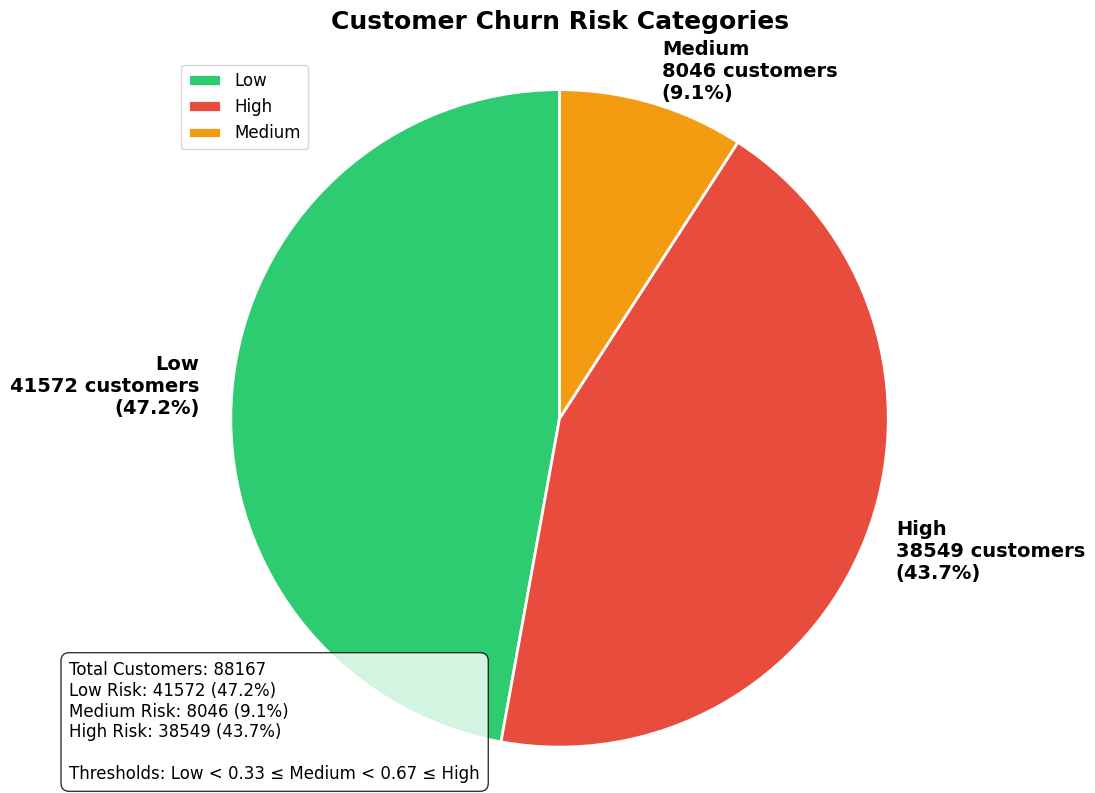

In [ ]:
visualizePredictions(y_pred_scaled, thresholds = (0.33, 0.67), figsize=(10, 8))

In [ ]:
evaluate_regression_model(y_true = y_test, y_pred = y_pred_reg)


Regression Model Evaluation:
Mean Squared Error (MSE): 0.0450
Root Mean Squared Error (RMSE): 0.2120
Mean Absolute Error (MAE): 0.1292
R² Score: 0.8168


{'mse': 0.044955119490623474,
 'rmse': np.float64(0.21202622359185544),
 'mae': 0.12920694053173065,
 'r2': 0.81676185131073}

In [ ]:
import pickle

pickle.dump(model, open("xgboost_model.pkl", "wb"))

pickle.dump(scaler, open("scaler.pkl", "wb"))